<a href="https://colab.research.google.com/github/jingvf/IDS/blob/main/%E2%80%9CTCN_BiLSTM_Atten_multi_ipynb%E2%80%9D_epochs%3D2%2C_batch_size%3D256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model

In [5]:
df = pd.read_csv('/content/drive/MyDrive/IIoTdatabase/DNN-EdgeIIoT-dataset.csv', low_memory=False)
df.head(5)

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,2021 11:44:10.081753000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
1,2021 11:44:10.162218000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,4.0,MQTT,0,0.0,4.0,0.0,0.0,0.0,0,Normal
2,2021 11:44:10.162271000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
3,2021 11:44:10.162641000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
4,2021 11:44:10.166132000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,Temperature_and_Humidity,24.0,0.0,0.0,0.0,0.0,0,Normal


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219201 entries, 0 to 2219200
Data columns (total 63 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   frame.time                 object 
 1   ip.src_host                object 
 2   ip.dst_host                object 
 3   arp.dst.proto_ipv4         object 
 4   arp.opcode                 float64
 5   arp.hw.size                float64
 6   arp.src.proto_ipv4         object 
 7   icmp.checksum              float64
 8   icmp.seq_le                float64
 9   icmp.transmit_timestamp    float64
 10  icmp.unused                float64
 11  http.file_data             object 
 12  http.content_length        float64
 13  http.request.uri.query     object 
 14  http.request.method        object 
 15  http.referer               object 
 16  http.request.full_uri      object 
 17  http.request.version       object 
 18  http.response              float64
 19  http.tls_port              float64
 20  tc

In [7]:
print(df['Attack_type'].value_counts())
print(df['Attack_label'].value_counts())
print(df['Attack_type'].unique())
print(df['Attack_label'].unique())

Attack_type
Normal                   1615643
DDoS_UDP                  121568
DDoS_ICMP                 116436
SQL_injection              51203
Password                   50153
Vulnerability_scanner      50110
DDoS_TCP                   50062
DDoS_HTTP                  49911
Uploading                  37634
Backdoor                   24862
Port_Scanning              22564
XSS                        15915
Ransomware                 10925
MITM                        1214
Fingerprinting              1001
Name: count, dtype: int64
Attack_label
0    1615643
1     603558
Name: count, dtype: int64
['Normal' 'MITM' 'Uploading' 'Ransomware' 'SQL_injection' 'DDoS_HTTP'
 'DDoS_TCP' 'Password' 'Port_Scanning' 'Vulnerability_scanner' 'Backdoor'
 'XSS' 'Fingerprinting' 'DDoS_UDP' 'DDoS_ICMP']
[0 1]


In [8]:
drop_columns = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4",

         "http.file_data","http.request.full_uri","icmp.transmit_timestamp",

         "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",

         "tcp.dstport", "udp.port", "mqtt.msg"]
drop_columns2 = ["http.request.method", "http.referer", "http.request.version", "dns.qry.name.len", "mqtt.conack.flags","mqtt.protoname", "mqtt.topic"]
df.drop(drop_columns, axis=1, inplace=True)
# 删除无效列
df.drop(drop_columns2, axis=1, inplace=True)
df.head(5)

,arp.opcode,arp.hw.size,icmp.checksum,icmp.seq_le,icmp.unused,http.content_length,http.response,http.tls_port,tcp.ack,tcp.ack_raw,...,mqtt.msg_decoded_as,mqtt.msgtype,mqtt.proto_len,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.153346e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Normal
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.447945e+08,...,0.0,1.0,4.0,0.0,4.0,0.0,0.0,0.0,0,Normal
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3.153346e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Normal
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3.153346e+09,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Normal
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.447945e+08,...,0.0,3.0,0.0,24.0,0.0,0.0,0.0,0.0,0,Normal


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219201 entries, 0 to 2219200
Data columns (total 41 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   arp.opcode                 float64
 1   arp.hw.size                float64
 2   icmp.checksum              float64
 3   icmp.seq_le                float64
 4   icmp.unused                float64
 5   http.content_length        float64
 6   http.response              float64
 7   http.tls_port              float64
 8   tcp.ack                    float64
 9   tcp.ack_raw                float64
 10  tcp.checksum               float64
 11  tcp.connection.fin         float64
 12  tcp.connection.rst         float64
 13  tcp.connection.syn         float64
 14  tcp.connection.synack      float64
 15  tcp.flags                  float64
 16  tcp.flags.ack              float64
 17  tcp.len                    float64
 18  tcp.seq                    float64
 19  udp.stream                 float64
 20  ud

In [10]:
# 删除缺失值
df.dropna(axis=0, how='any', inplace=True)
# 删除所有的重复行，仅保留第一次出现的行。这一步骤确保了数据集中每一行都是独一无二的，有助于避免模型训练时的偏差。
df.drop_duplicates(subset=None, keep="first", inplace=True)
# 打乱数据集
df = shuffle(df)

In [11]:
print(df.isna().sum()) #空值数量
# 发现都没有字符型，所以不需要数值化

arp.opcode                   0
arp.hw.size                  0
icmp.checksum                0
icmp.seq_le                  0
icmp.unused                  0
http.content_length          0
http.response                0
http.tls_port                0
tcp.ack                      0
tcp.ack_raw                  0
tcp.checksum                 0
tcp.connection.fin           0
tcp.connection.rst           0
tcp.connection.syn           0
tcp.connection.synack        0
tcp.flags                    0
tcp.flags.ack                0
tcp.len                      0
tcp.seq                      0
udp.stream                   0
udp.time_delta               0
dns.qry.name                 0
dns.qry.qu                   0
dns.qry.type                 0
dns.retransmission           0
dns.retransmit_request       0
dns.retransmit_request_in    0
mqtt.conflag.cleansess       0
mqtt.conflags                0
mqtt.hdrflags                0
mqtt.len                     0
mqtt.msg_decoded_as          0
mqtt.msg

In [12]:
from sklearn.model_selection import train_test_split
#Independent features
# 多分类
X= df.iloc[:,:-1]
y= df.iloc[:,-1]

print(X.shape)
print(y.shape)

(1909671, 40)
(1909671,)


In [23]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training data further into train (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1336769, 40)
(190967, 40)
(381935, 40)
(1336769,)
(190967,)
(381935,)


In [24]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable to numerical labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
# Now apply one-hot encoding
y_train_encoded = to_categorical(y_train_encoded, num_classes=15)
y_val_encoded = to_categorical(y_val_encoded, num_classes=15)
y_test_encoded = to_categorical(y_test_encoded, num_classes=15)

In [25]:
unique_values = np.unique(y_train_encoded)
# 打印唯一值
print(len(unique_values))
print(y_train_encoded)
print(y_val_encoded[3])
print(y_test_encoded[3])

2
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [26]:
# 标准化
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout, Bidirectional, BatchNormalization, Attention

class TemporalBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters, kernel_size, dilation_rate, **kwargs):
        super(TemporalBlock, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv1D(filters=num_filters,
                                            kernel_size=kernel_size,
                                            dilation_rate=dilation_rate,
                                            padding='causal',
                                            activation='relu')
        self.conv2 = tf.keras.layers.Conv1D(filters=num_filters,
                                            kernel_size=kernel_size,
                                            dilation_rate=dilation_rate,
                                            padding='causal',
                                            activation='relu')
        self.downsample = tf.keras.layers.Conv1D(filters=num_filters,
                                                 kernel_size=1,
                                                 padding='same') if kwargs.get('downsample') else None
        self.relu = tf.keras.layers.ReLU()

    def call(self, x, training=False):
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            x = self.downsample(x)
        return self.relu(out + x)

class TCN(tf.keras.layers.Layer):
    def __init__(self, num_filters, kernel_size, dilations, **kwargs):
        super(TCN, self).__init__(**kwargs)
        self.temporal_blocks = [TemporalBlock(num_filters, kernel_size, dilation) for dilation in dilations]

    def call(self, x, training=False):
        for block in self.temporal_blocks:
            x = block(x, training=training)
        return x

def tcn_bilstm_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # TCN层
    x = TCN(num_filters=64, kernel_size=10, dilations=[1, 2, 4, 8])(inputs)

    # 双向LSTM层
    bilstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
    bilstm_out = BatchNormalization()(bilstm_out)

    # 注意力层
    attention_out = Attention()([bilstm_out, bilstm_out])
    attention_out = BatchNormalization()(attention_out)

    # 重新调整形状
    x = Flatten()(attention_out)

    # 全连接层
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [29]:
input_shape = (X_train.shape[1], 1)
num_classes = 15
model = tcn_bilstm_attention_model(input_shape, num_classes)
model.summary()
# plot_model(model)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 40, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tcn_1 (TCN)               │ (None, 40, 64)         │        287,872 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 40, 128)        │         66,048 │ tcn_1[0][0]            │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 40, 128)        │            512 │ bidirectional_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 40, 128)        │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 40, 128)        │            512 │ attention_1[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 5120)           │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │        655,488 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 15)             │          1,935 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,012,367 (3.86 MB)

 Trainable params: 1,011,855 (3.86 MB)

 Non-trainable params: 512 (2.00 KB)

In [30]:
train_start_time = time.time()
# Train the model
history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=2, batch_size=256)
# Record the ending time
train_end_time = time.time()

# Record the starting time for testing
test_start_time = time.time()
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded, batch_size=32)
# Record the ending time for testing
test_end_time = time.time()

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Calculate and print the training time
train_time = train_end_time - train_start_time
print(f"Training time: {train_time:.2f} seconds")

# Calculate and print the testing time
test_time = test_end_time - test_start_time
print(f"Testing time: {test_time:.2f} seconds")

Epoch 1/2
5222/5222 ━━━━━━━━━━━━━━━━━━━━ 4112s 786ms/step - accuracy: 0.8933 - loss: 0.2975 - val_accuracy: 0.9199 - val_loss: 0.2102
Epoch 2/2
5222/5222 ━━━━━━━━━━━━━━━━━━━━ 4102s 785ms/step - accuracy: 0.9128 - loss: 0.2239 - val_accuracy: 0.9234 - val_loss: 0.1910
11936/11936 ━━━━━━━━━━━━━━━━━━━━ 422s 35ms/step - accuracy: 0.9235 - loss: 0.1908
Test Loss: 0.1903
Test Accuracy: 0.9239
Training time: 8275.25 seconds
Testing time: 442.50 seconds


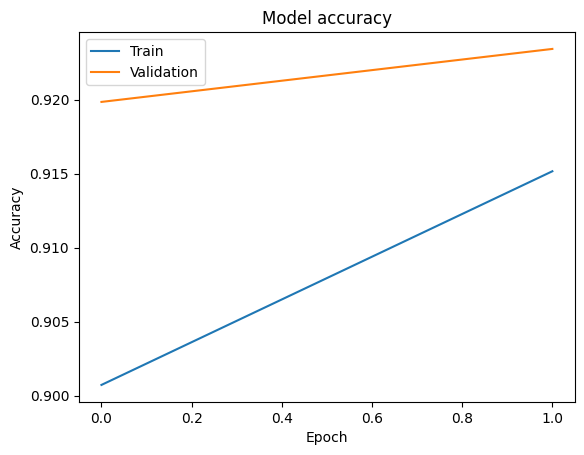

<Figure size 640x480 with 0 Axes>

In [31]:
# Plot the training and validation accuracy over the epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('acc_plo.jpg')

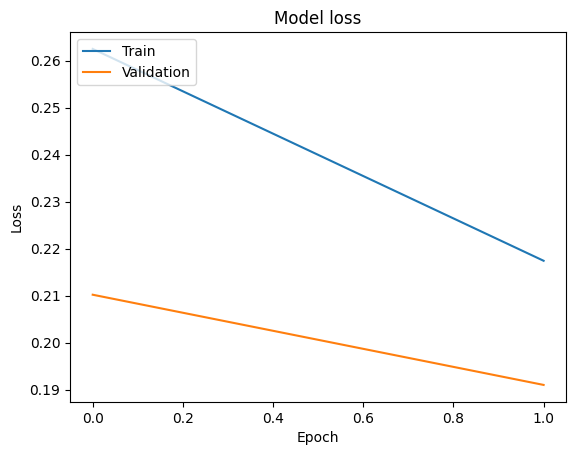

<Figure size 640x480 with 0 Axes>

In [32]:
# Plot the training and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('los_plo.jpg')

In [33]:
y_pred = model.predict(np.expand_dims(X_test, axis=2))

11936/11936 ━━━━━━━━━━━━━━━━━━━━ 412s 34ms/step


In [35]:
attack_types = ['Normal', 'MITM', 'Uploading', 'Ransomware', 'SQL_injection', 'DDoS_HTTP',
                'DDoS_TCP', 'Password', 'Port_Scanning', 'Vulnerability_scanner', 'Backdoor',
                'XSS', 'Fingerprinting', 'DDoS_UDP', 'DDoS_ICMP']
attacks = {attack: idx for idx, attack in enumerate(attack_types)}


In [38]:
y_pred_classes = np.argmax(y_pred, axis=1)

# Inverse the 'attacks' dictionary to map back numbers to names
inverse_attacks = {v: k for k, v in attacks.items()}

if y_test_encoded.ndim == 2:  # Check if it's a 2D array (one-hot encoded)
    y_test_encoded = np.argmax(y_test_encoded, axis=1)

# Generate the classification report with attack names instead of numbers
class_report = classification_report(y_test_encoded, y_pred_classes, target_names=[inverse_attacks[i] for i in range(len(inverse_attacks))])

print(class_report)

                       precision    recall  f1-score   support

               Normal       0.80      0.74      0.77      4750
                 MITM       0.59      0.58      0.59      9824
            Uploading       0.99      1.00      1.00     13694
           Ransomware       0.78      1.00      0.88      9865
        SQL_injection       1.00      1.00      1.00     24205
            DDoS_HTTP       0.78      0.04      0.08       171
             DDoS_TCP       1.00      0.92      0.96        85
             Password       1.00      1.00      1.00    272548
        Port_Scanning       0.79      0.14      0.23      9932
Vulnerability_scanner       1.00      0.49      0.66      4036
             Backdoor       0.95      0.53      0.68      1917
                  XSS       0.31      0.88      0.46     10275
       Fingerprinting       0.71      0.20      0.31      7455
             DDoS_UDP       0.94      0.82      0.87     10165
            DDoS_ICMP       0.95      0.03      0.05  

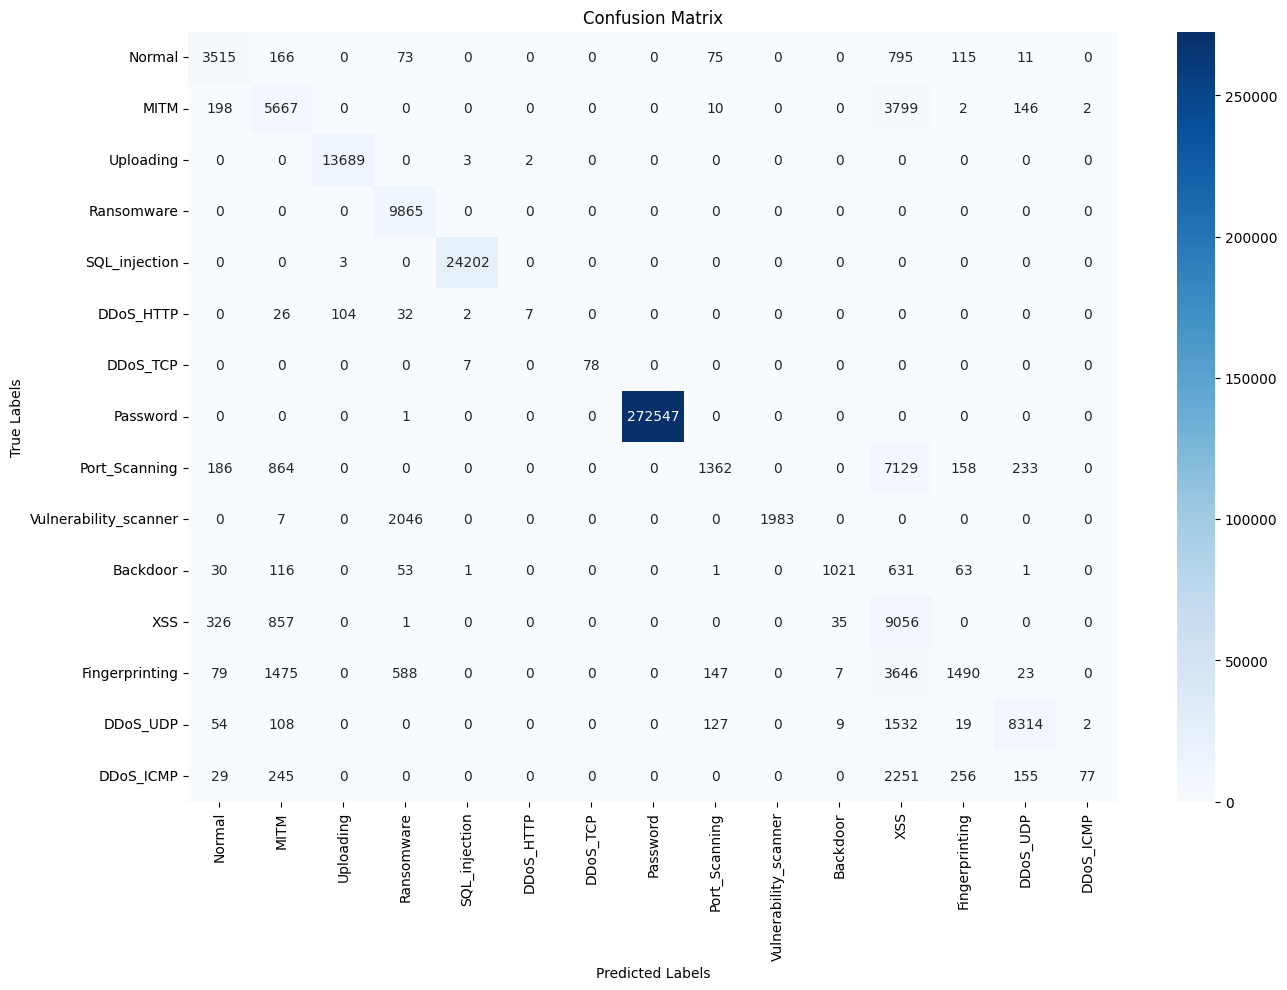

<Figure size 640x480 with 0 Axes>

In [40]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_test_encoded, y_pred_classes)

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('con_mat.jpg')

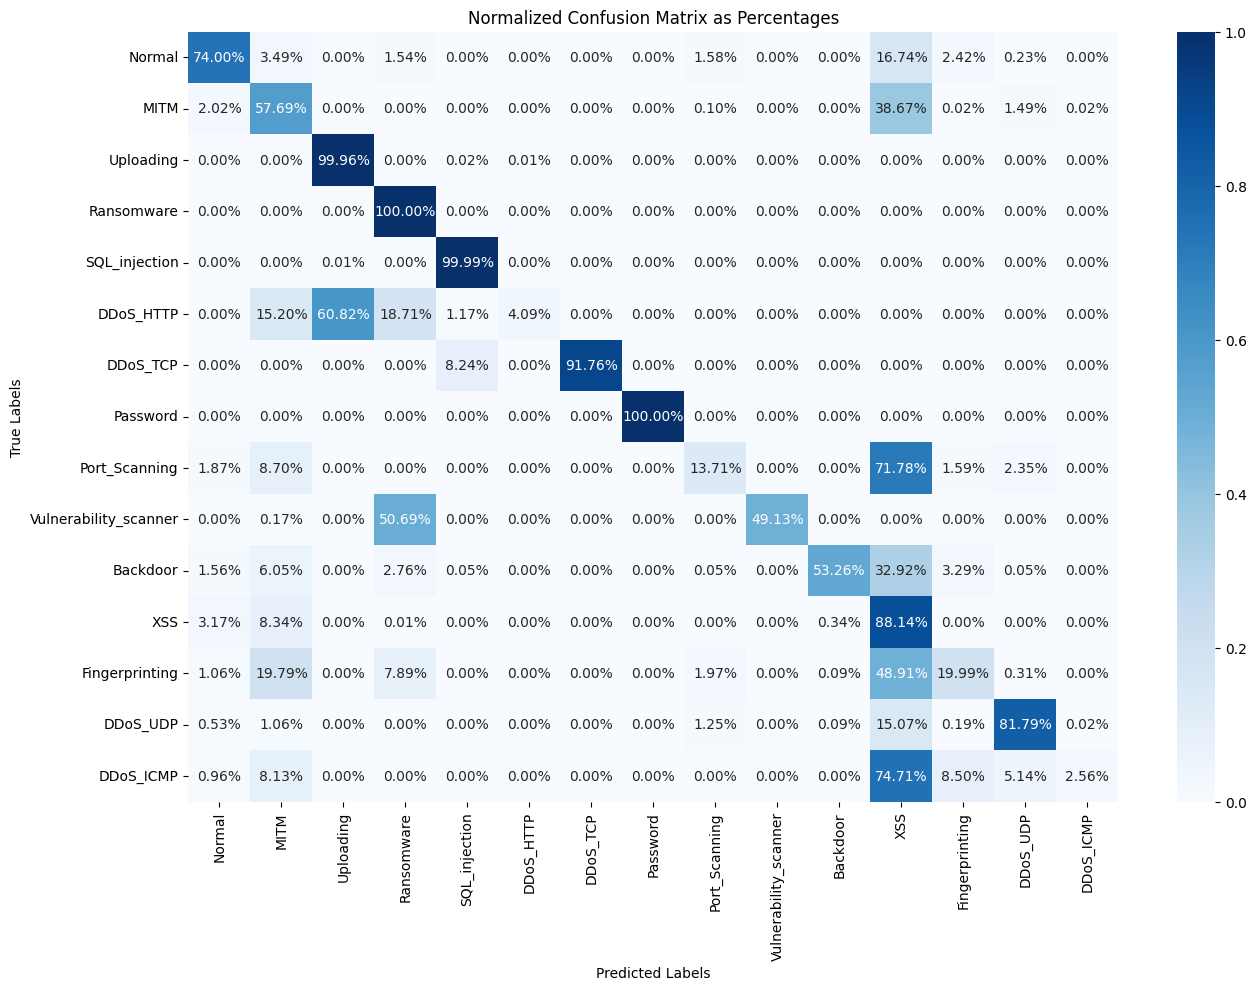

<Figure size 640x480 with 0 Axes>

In [41]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_test_encoded, y_pred_classes)

# Normalize the confusion matrix by dividing each value by the sum of its row (i.e., the number of true instances for each label)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix as Percentages')
plt.show()
plt.savefig('con_per.jpg')